In [333]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import astropy.io.fits as fits

    
def spatialCoords(l,b,D, origin='galcenter'):
    '''
    converts a set of galactic coordinates to 3-D cartesian
    coordinates centered at the sun or the galactic center.
    
    Parameters:
       origin: 'sun' or 'galcenter'
       l, b: galactic coordinates in degrees
       D: distance from the sun to each object, in parsec
    '''
    cl=np.cos(l*np.pi/180)
    sl=np.sin(l*np.pi/180)
    cb=np.cos(b*np.pi/180)
    sb=np.sin(b*np.pi/180)
    Rsun=8340 #distance from the sun to the GC 
    zsun=27 #the height scale of the sun is set to 27pc according to Chen et al. 2003 
    if origin=='galcenter':
        x=Rsun-D*cl*cb
        z=zsun+D*sb
    else:
        if origin=='galcenterz0':
            x=Rsun-D*cl*cb
            z=0+D*sb
        else:
            x=D*cl*cb
            z=D*sb
    y=-D*sl*cb
    
    return x,y,z

def VrpmUVW(ra, dec, Vr, pmra, pmdec, D, Vrerr, pmraerr, pmdecerr, Derr, velsun):
    '''
    Vpm2UVW converts radial velocities and proper motions to 3D velocities.
    Parameters:
    Vr: radial velocity from observation
    pmra, pmdec: proper motion in equatorial coordinates
    ra,dec:equatorial coordinates
    D: distance to the Sun in pc.
    Return:
    U, V, W: 3D velocity components with respect to LSR
    REF:Johnson & Soderblom(1987)
    '''
    #velsun = [10,5.25,7.17]
    #velsun = [9.58,10.52,7.01]
#    velsun = [9.58,20,7.01]
#    T=[[-0.06699, -0.87276, -0.48354]
#       [+0.49273, -0.45035, +0.74458] 
#       [-0.86760, -0.18837, +0.46020]]
    k = 4.74057 
    ra0 = ra*np.pi/180.0
    dec0 = dec*np.pi/180.0
    cra = np.cos(ra0)
    sra = np.sin(ra0)
    cdec = np.cos(dec0)
    sdec = np.sin(dec0)
    
    
    B11=-0.063491*cra*cdec -0.86554 *sra*cdec -0.496799*sdec
    B12= 0.063491*sra       -0.86554 *cra       +0
    B13= 0.063491*cra*sdec +0.86554 *sra*sdec -0.496799*cdec
    
    B21= 0.493076*cra*cdec -0.460007*sra*cdec +0.738424*sdec
    B22=-0.493076*sra       -0.460007*cra       +0
    B23=-0.493076*cra*sdec +0.460007*sra*sdec +0.738424*cdec
    
    B31=-0.867666*cra*cdec -0.198076*sra*cdec +0.455984*sdec
    B32= 0.867666*sra       -0.198076*cra       +0
    B33= 0.867666*cra*sdec +0.198076*sra*sdec +0.455984*cdec
    
    U = velsun[0]+Vr*B11+k*pmra*D*B12/1000.0+k*pmdec*D*B13/1000.0
    V = velsun[1]+Vr*B21+k*pmra*D*B22/1000.0+k*pmdec*D*B23/1000.0
    W = velsun[2]+Vr*B31+k*pmra*D*B32/1000.0+k*pmdec*D*B33/1000.0
    Uerr = np.sqrt(B11**2*Vrerr**2+\
        (k*B12/1000.0)**2*(D**2*pmraerr**2+pmra**2*Derr**2)+\
        (k*B13/1000.0)**2*(Derr**2*pmdec**2+pmdecerr**2*D**2))
    Verr=np.sqrt(B21**2*Vrerr**2+\
        (k*B22/1000.0)**2*(D**2*pmraerr**2+pmra**2*Derr**2)+\
        (k*B23/1000.0)**2*(Derr**2*pmdec**2+pmdecerr**2*D**2))
    Werr=np.sqrt(B31**2*Vrerr**2+\
        (k*B32/1000.0)**2*(D**2*pmraerr**2+pmra**2*Derr**2)+\
        (k*B33/1000.0)**2*(Derr**2*pmdec**2+pmdecerr**2*D**2))
        
    return U,V,W,Uerr,Verr,Werr



def velocitycart2cylindrical(U,V,W,l,b,dist,Uerr,Verr,Werr,disterr,Vlsr,Rsun):
    '''
        Convert the UVW to velocity compoennts in cylindrical coordinates
        Parameters:
        U: velocity in X, in km/s
        V: velocity in Y, in km/s
        W: velocity in Y, in km/s
        l,b: Galactic coordniates, in degrees
        dist: distance in pc
        Vlsr circular speed at LSR
        Rsun: distance from the Galactic center to the Sun;\
    '''

    cbsl=np.cos(np.deg2rad(b))*np.sin(np.deg2rad(l))
    cbcl=np.cos(np.deg2rad(b))*np.cos(np.deg2rad(l))
    tanphi=(dist*cbsl/(Rsun-dist*cbcl))
    tanphierr2=disterr**2*(cbsl**2*Rsun**2)/(Rsun-dist*cbcl)**4
    phi=np.arctan(tanphi)
    phierr2=tanphierr2/(1+tanphi**2)**2
    VR=-np.cos(phi)*U+np.sin(phi)*(V+Vlsr)
    VPhi=np.sin(phi)*U+np.cos(phi)*(V+Vlsr)
    VZ=W
    VRerr=np.sqrt((np.cos(phi)**2)*(Uerr**2)+(np.sin(phi)**2)*(Verr**2)+\
                  ((U*np.sin(phi)+(V+Vlsr)*np.cos(phi))**2)*phierr2)
    VPhierr=np.sqrt((np.sin(phi)**2)*(Uerr**2)+(np.cos(phi)**2)*(Verr**2)+\
                  ((U*np.cos(phi)-(V+Vlsr)*np.sin(phi))**2)*phierr2)
    VZerr=Werr
    phi0=phi
    return VR,VPhi,VZ,VRerr,VPhierr,VZerr,phi0
    
def velocity(tgas0, V0, velsun, Rsun):
    '''
        derive velocities with lamost-tgas catalog
        Parameters:
        tgas0: the lamost-tgas catalog
        V0: the circular speed at LSR
        velsun: the solar motion wrt. the LSR
        Rsun: the distance from the Galactic center to the Sun
    '''
    U, V, W, Uerr, Verr, Werr =\
        VrpmUVW(tgas0.ra_tgas,tgas0.dec_tgas,tgas0.rv+5.7,tgas0.pmra_tgas,tgas0.pmdec_tgas,\
        tgas0.dist_tgas,np.repeat(5.0,len(tgas0.obsid)),\
        tgas0.pmra_error_tgas,tgas0.pmdec_error_tgas,\
        tgas0.dist_tgas*tgas0.dist_error_tgas, velsun)
    VR,VPHI,VZ,VRerr,VPHIerr,VZerr, PHI0 = velocitycart2cylindrical(U,V,W,\
        tgas0.l_tgas,tgas0.b_tgas,\
        tgas0.dist_tgas,Uerr,Verr,Werr,tgas0.dist_tgas*tgas0.dist_error_tgas,\
        V0,Rsun)
    return U, V, W, Uerr, Verr, Werr,VR,VPHI,VRerr,VPHIerr,VZ,VZerr


def loadData(filename):
    '''
    Read fits data
    '''
    tchfits = fits.open(filename)
    tgas = tchfits[1].data
    return tgas

 
def drawInplaneVelDist(VR,VPHI,FeH):
    '''
    draw distribution of VR vs. VPhi
    '''
    fig = plt.figure()
    ax = fig.add_subplot(111)
    #ax.plot(VR,VPHI,'k.',markersize=2)
    sc = ax.scatter(VR, VPHI, c=FeH, alpha=0.5, vmin=-0.6, vmax=+0.3, edgecolors='none')
    ax.set_xlim([-150,150])
    ax.set_ylim([0,300])
    plt.xlabel('VR')
    plt.ylabel('VPhi')
    fig.colorbar(sc)
    fig.show()
    
    
def drawHRdiagram(Teff,MK):
    '''
    draw Teff-MK (HR) diagram
    '''
    Tgrid = np.linspace(3500,9000,num=50)
    Mgrid = np.linspace(-10,10,num=100)
    HRD,xedges,yedges = np.histogram2d(MK,Teff,bins=[Mgrid,Tgrid])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    #ax.imshow(HRD,extent=[yedges[0],yedges[-1],xedges[-1],xedges[0]])
    ax.contour(np.log(HRD+1.),20,extent=[yedges[0],yedges[-1],xedges[0],xedges[-1]])    
    ax.set_aspect('auto')
    ax.set_xlim([8500,3600])
    ax.set_ylim([10,-10])
    plt.xlabel(r'$T_{\rm eff}$')
    plt.ylabel(r'$M_K$')
    fig.show()
    
    
def drawSpatialDist(x,y,z):
    fig = plt.figure(figsize=[14,6])
    ax_xy = fig.add_subplot(2,2,1)
    ax_xy.plot(x/1.0e3,y/1.0e3,'k.',markersize=2)
    plt.xlabel('X (kpc)')
    plt.ylabel('Y (kpc)')
    ax_xy.set_xlim([6.5,10])
    ax_xy.set_ylim([-2,2])
    ####
    ax_yz = fig.add_subplot(2,2,4)
    ax_yz.plot(y/1.0e3,z/1.0e3,'k.',markersize=2)
    plt.xlabel('Y (kpc)')
    plt.ylabel('Z (kpc)')
    ax_yz.set_xlim([-2,2])
    ax_yz.set_ylim([-2,2])
    ####
    ax_xz = fig.add_subplot(2,2,3)
    ax_xz.plot(x/1.0e3,z/1.0e3,'k.',markersize=2)
    plt.xlabel('X (kpc)')
    plt.ylabel('Z (kpc)')
    ax_xz.set_xlim([6.5,10])
    ax_xz.set_ylim([-2,2])

def median2d(X,Y,Z,Xgrid,Ygrid,N):
    mp = np.ndarray([len(Ygrid)-1,len(Xgrid)-1])
    for i in xrange(len(Ygrid)-1):
        for j in xrange(len(Xgrid)-1):
            ind = (X>=Xgrid[j]) * (X<=Xgrid[j+1]) * (Y>=Ygrid[i]) * (Y<=Ygrid[i+1])
            if np.sum(ind)>N:
                mp[i,j] = median(Z[ind])
            else:
                mp[i,j] = np.nan
    return mp


In [130]:
#calculate MC error for individual stars

def velocity1(ra_tgas,dec_tgas,l_tgas,b_tgas,rv,pmra_tgas,pmdec_tgas,dist_tgas, V0, velsun, Rsun):
    '''
        derive velocities with lamost-tgas catalog
        Parameters:
        tgas0: the lamost-tgas catalog
        V0: the circular speed at LSR
        velsun: the solar motion wrt. the LSR
        Rsun: the distance from the Galactic center to the Sun
    '''
    U, V, W, Uerr, Verr, Werr =\
        VrpmUVW(ra_tgas,dec_tgas,rv+5.7,pmra_tgas,pmdec_tgas,\
        dist_tgas,np.repeat(0.0,len(rv)),\
        np.repeat(0.0,len(rv)),np.repeat(0.0,len(rv)),\
        np.repeat(0.0,len(rv)), velsun)
    VR,VPHI,VZ,VRerr,VPHIerr,VZerr, PHI0 = velocitycart2cylindrical(U,V,W,\
        l_tgas,b_tgas,\
        dist_tgas,Uerr,Verr,Werr,np.repeat(0.0,len(rv)),\
        V0,Rsun)
    return VR,VPHI,VZ

V0 = 238 #km/s
velsun1 = [9.58,10.52,7.01] #Tian et al. 2015
Rsun = 8340 #Reid 2014 in parsec
M = 100
velerr = np.zeros([len(tgas.l_tgas),6])
for i in xrange(len(tgas.l_tgas)):
    rv = tgas.rv[i]+5.7+sp.random.normal(loc=0,scale=5.0,size=M)
    dist = tgas.dist_tgas[i]+sp.random.normal(loc=0,scale=tgas.dist_error_tgas[i]*\
                                                 tgas.dist_tgas[i],size=M)
    pmra = tgas.pmra_tgas[i]+sp.random.normal(loc=0,scale=tgas.pmra_error_tgas[i],size=M)
    pmde = tgas.pmdec_tgas[i]+sp.random.normal(loc=0,scale=tgas.pmdec_error_tgas[i],size=M)
    VR,VPHI,VZ = velocity1(np.repeat(tgas.ra_tgas[i],M),\
                           np.repeat(tgas.dec_tgas[i],M),\
                           np.repeat(tgas.l_tgas[i],M),\
                           np.repeat(tgas.b_tgas[i],M),\
                           rv,pmra,pmde,dist,V0,velsun1,Rsun)
    meanVR = np.mean(VR)
    meanVPHI = np.mean(VPHI)
    meanVZ = np.mean(VZ)
    sig_RR = np.sum((VR-meanVR)*(VR-meanVR))/M
    sig_RPHI = np.sum((VR-meanVR)*(VPHI-meanVPHI))/M
    sig_RZ = np.sum((VR-meanVR)*(VZ-meanVZ))/M
    sig_PHIPHI = np.sum((VPHI-meanVPHI)*(VPHI-meanVPHI))/M
    sig_PHIZ = np.sum((VZ-meanVZ)*(VPHI-meanVPHI))/M
    sig_ZZ = np.sum((VZ-meanVZ)*(VZ-meanVZ))/M
    velerr[i,:]=[sig_RR,sig_RPHI,sig_RZ,sig_PHIPHI,sig_PHIZ,sig_ZZ]
    if np.mod(i,10000)==0:
        print i
        

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in greater
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in less
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in greater_equal
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in less
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in greater
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in less_equal
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in greater_equal


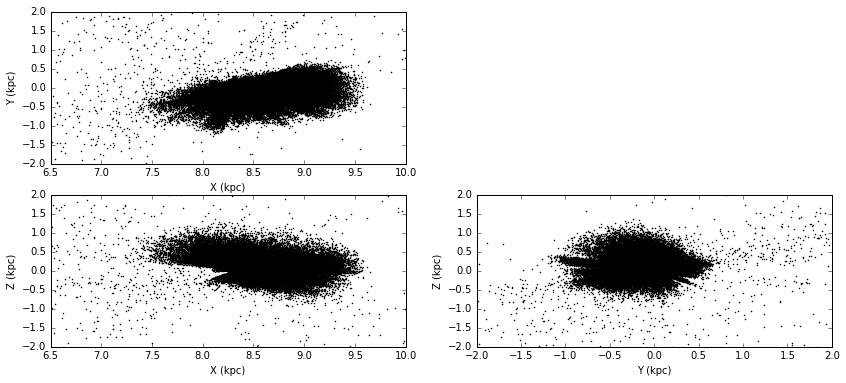

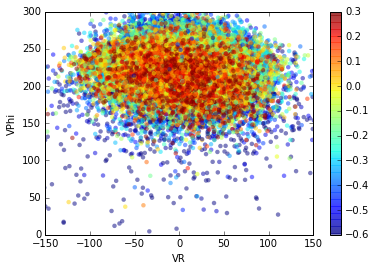

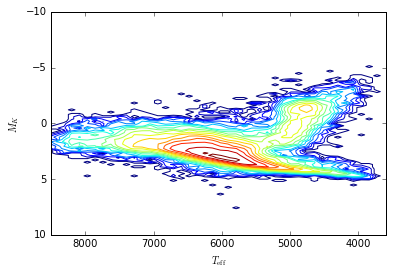

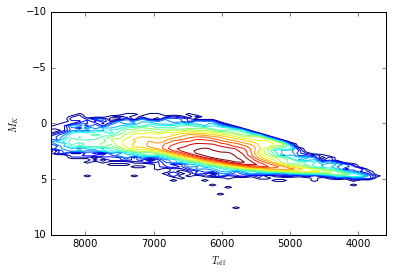

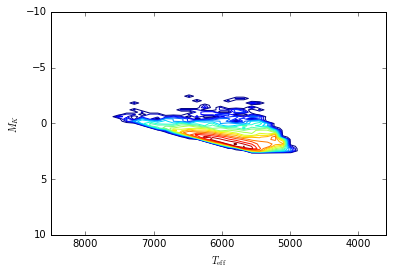

In [334]:
#data file is in dropbox with link: https://www.dropbox.com/s/66uy7ipp0t3gbmp/LAMOST_DR3_TGAS.fits?dl=0
filename = '/Users/chaoliu/pyw/TGAS/LAMOST_DR3_TGAS.fits'
tgas = loadData(filename)
V0 = 238 #km/s
velsun1 = [9.58,10.52,7.01] #Tian et al. 2015
Rsun = 8340 #Reid 2014 in parsec
X,Y,Z = spatialCoords(tgas.l_tgas,tgas.b_tgas,tgas.dist_tgas)
R = np.sqrt(X**2+Y**2)
Phi = np.arctan(Y/X)
ind = tgas.dist_error_tgas<0.3
drawSpatialDist(X[ind],Y[ind],Z[ind])
U, V, W, Uerr, Verr, Werr,VR,VPHI,VRerr,VPHIerr,VZ,VZerr = velocity(tgas,V0,velsun1,Rsun)
ind = (tgas.dist_error_tgas<0.3) * (np.abs(Z)<300)
drawInplaneVelDist(VR[ind],VPHI[ind],tgas.feh[ind])
drawHRdiagram(tgas.teff[ind],tgas.MK_tgas[ind])
ind_MS = (tgas.dist_error_tgas<0.3) * (tgas.dist_tgas<1000) *\
    (((tgas.teff>3500) * (tgas.teff<6500) * (tgas.MK_tgas>((4.+1.)/(4000.-6500.)*(tgas.teff-6500.)-1.))) +\
    ((tgas.teff<8500) * (tgas.teff>=6500) * (tgas.MK_tgas>-1)))
ind_SGB = (tgas.dist_error_tgas<0.3) * (tgas.MK_tgas<2.5) *(tgas.dist_tgas<1000) *\
    (((tgas.teff>5000) * (tgas.teff<5500) * (tgas.MK_tgas>((2.5+1.)/(5000.-5500.)*(tgas.teff-5500.)-1.))) +\
    ((tgas.teff<=7500) * (tgas.teff>=5500) * (tgas.MK_tgas<((2.5+0.5)/(5500.-7500.)*(tgas.teff-7500.)-0.5))))
    #line1: 5500,2.5;7500,-0.5
    #line2: 5500,-1;5000,2.5
    #line3: 5000-5500,2.5
drawHRdiagram(tgas.teff[ind_MS],tgas.MK_tgas[ind_MS])
drawHRdiagram(tgas.teff[ind_SGB],tgas.MK_tgas[ind_SGB])

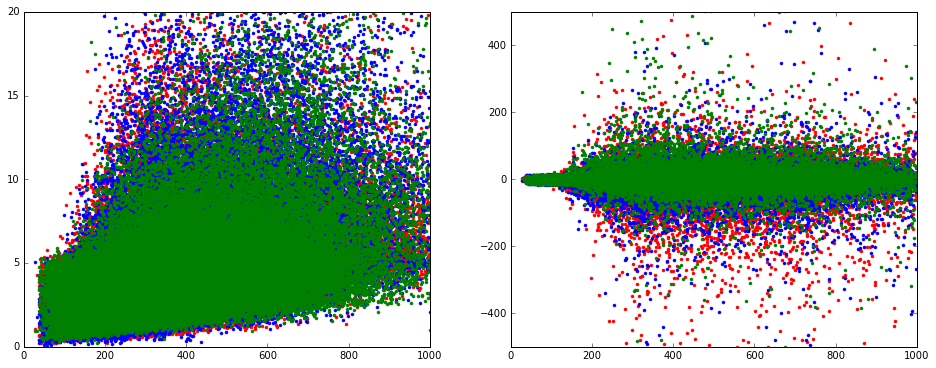

In [133]:
fig = plt.figure(figsize=[16,6])
ax = fig.add_subplot(121)
ax.plot(tgas.dist_tgas[ind_MS],np.sqrt(velerr[ind_MS,0]),'r.')
ax.plot(tgas.dist_tgas[ind_MS],np.sqrt(velerr[ind_MS,3]),'b.')
ax.plot(tgas.dist_tgas[ind_MS],np.sqrt(velerr[ind_MS,5]),'g.')
ax.set_ylim([0,20])

ax = fig.add_subplot(122)
ax.plot(tgas.dist_tgas[ind_MS],velerr[ind_MS,1],'r.')
ax.plot(tgas.dist_tgas[ind_MS],velerr[ind_MS,2],'b.')
ax.plot(tgas.dist_tgas[ind_MS],velerr[ind_MS,4],'g.')
ax.set_ylim([-500,500])

fig.show()

/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in greater_equal
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in less_equal


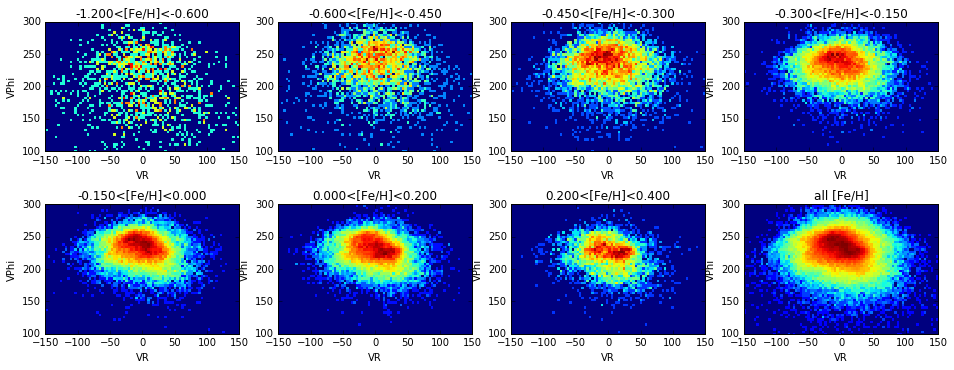

In [335]:
ind0 = ind_MS
fehgrid = np.array([-1.2,-0.6,-0.45,-0.3,-0.15,0,0.2,0.4])
fehcenter = (fehgrid[0:len(fehgrid)-1]+fehgrid[1:len(fehgrid)])/2.0
VRgrid = np.linspace(-150,150,81)
VPhigrid = np.linspace(0,300,81)
fig = plt.figure(figsize=[16,6])
for i in xrange(len(fehcenter)):
    ind = ind0 * (tgas.feh>=fehgrid[i]) * (tgas.feh<=fehgrid[i+1])
    ax = fig.add_subplot(2,4,i+1)
    #sc = ax.scatter(VR[ind], VPHI[ind], c=tgas.feh[ind], alpha=0.5, vmin=-0.6, vmax=+0.3, edgecolors='none')
    #ax.plot(VR[ind], VPHI[ind],'k.',markersize=2)
    mp,xgrid,ygrid = np.histogram2d(VR[ind], VPHI[ind],bins=[VRgrid,VPhigrid])
    ax.imshow(np.log(1.0+mp.T),interpolation='none',extent=[-150,150,300,0])
    #ax.contourf(np.log(1.+mp.T),20,interpolation='none',extent=[-150,150,0,300])
    ax.set_xlim([-150,150])
    ax.set_ylim([100,300])
    plt.title('%(a).3f<[Fe/H]<%(b).3f' % {'a':fehgrid[i],'b':fehgrid[i+1]})
    plt.xlabel('VR')
    plt.ylabel('VPhi')
ax = fig.add_subplot(2,4,8)
#sc = ax.scatter(VR[ind], VPHI[ind], c=tgas.feh[ind], alpha=0.5, vmin=-0.6, vmax=+0.3, edgecolors='none')
#ax.plot(VR[ind], VPHI[ind],'k.',markersize=2)
mp,xgrid,ygrid = np.histogram2d(VR[ind0], VPHI[ind0],bins=[VRgrid,VPhigrid])
ax.imshow(np.log(1.0+mp.T),interpolation='none',extent=[-150,150,300,0])
#ax.contourf(np.log(1.+mp.T),20,interpolation='none',extent=[-150,150,0,300])
ax.set_xlim([-150,150])
ax.set_ylim([100,300])
plt.title('all [Fe/H]')
plt.xlabel('VR')
plt.ylabel('VPhi')
fig.show()

/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in greater_equal
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in less_equal


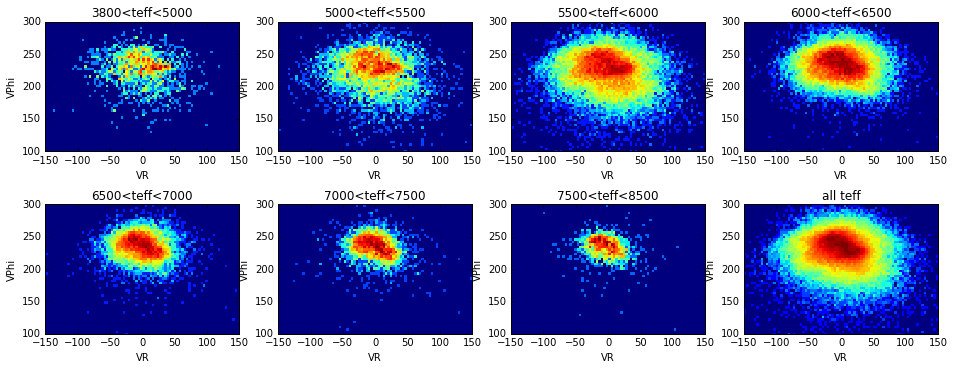

In [136]:
ind0 = ind_MS
teffgrid = np.array([3800,5000,5500,6000,6500,7000,7500,8500])
teffcenter = (teffgrid[0:len(teffgrid)-1]+teffgrid[1:len(teffgrid)])/2.0
VRgrid = np.linspace(-150,150,81)
VPhigrid = np.linspace(0,300,81)
fig = plt.figure(figsize=[16,6])
for i in xrange(len(teffcenter)):
    ind = ind0 * (tgas.teff>=teffgrid[i]) * (tgas.teff<=teffgrid[i+1])
    ax = fig.add_subplot(2,4,i+1)
    #sc = ax.scatter(VR[ind], VPHI[ind], c=tgas.feh[ind], alpha=0.5, vmin=-0.6, vmax=+0.3, edgecolors='none')
    #ax.plot(VR[ind], VPHI[ind],'k.',markersize=2)
    mp,xgrid,ygrid = np.histogram2d(VR[ind], VPHI[ind],bins=[VRgrid,VPhigrid])
    ax.imshow(np.log(1.0+mp.T),interpolation='none',extent=[-150,150,300,0])
    #ax.contourf(np.log(1.+mp.T),20,interpolation='none',extent=[-150,150,0,300])
    ax.set_xlim([-150,150])
    ax.set_ylim([100,300])
    plt.title('%(a).0f<teff<%(b).0f' % {'a':teffgrid[i],'b':teffgrid[i+1]})
    plt.xlabel('VR')
    plt.ylabel('VPhi')
ax = fig.add_subplot(2,4,8)
#sc = ax.scatter(VR[ind], VPHI[ind], c=tgas.feh[ind], alpha=0.5, vmin=-0.6, vmax=+0.3, edgecolors='none')
#ax.plot(VR[ind], VPHI[ind],'k.',markersize=2)
mp,xgrid,ygrid = np.histogram2d(VR[ind0], VPHI[ind0],bins=[VRgrid,VPhigrid])
ax.imshow(np.log(1.0+mp.T),interpolation='none',extent=[-150,150,300,0])
#ax.contourf(np.log(1.+mp.T),20,interpolation='none',extent=[-150,150,0,300])
ax.set_xlim([-150,150])
ax.set_ylim([100,300])
plt.title('all teff')
plt.xlabel('VR')
plt.ylabel('VPhi')
fig.show()

/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in greater_equal
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in less_equal
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:40: RuntimeWarning: invalid value encountered in greater_equal
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:40: RuntimeWarning: invalid value encountered in less_equal
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:65: RuntimeWarning: invalid value encountered in greater_equal
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:65: RuntimeWarning: invalid value encountered in less_equal


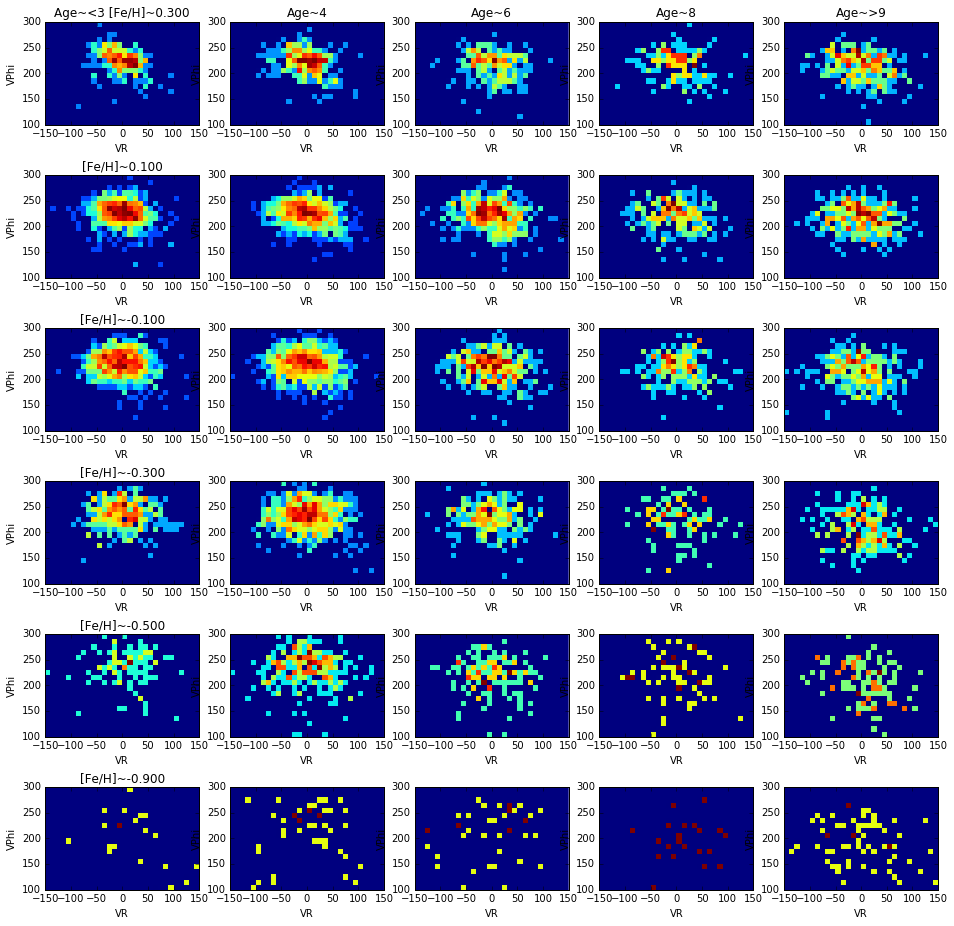

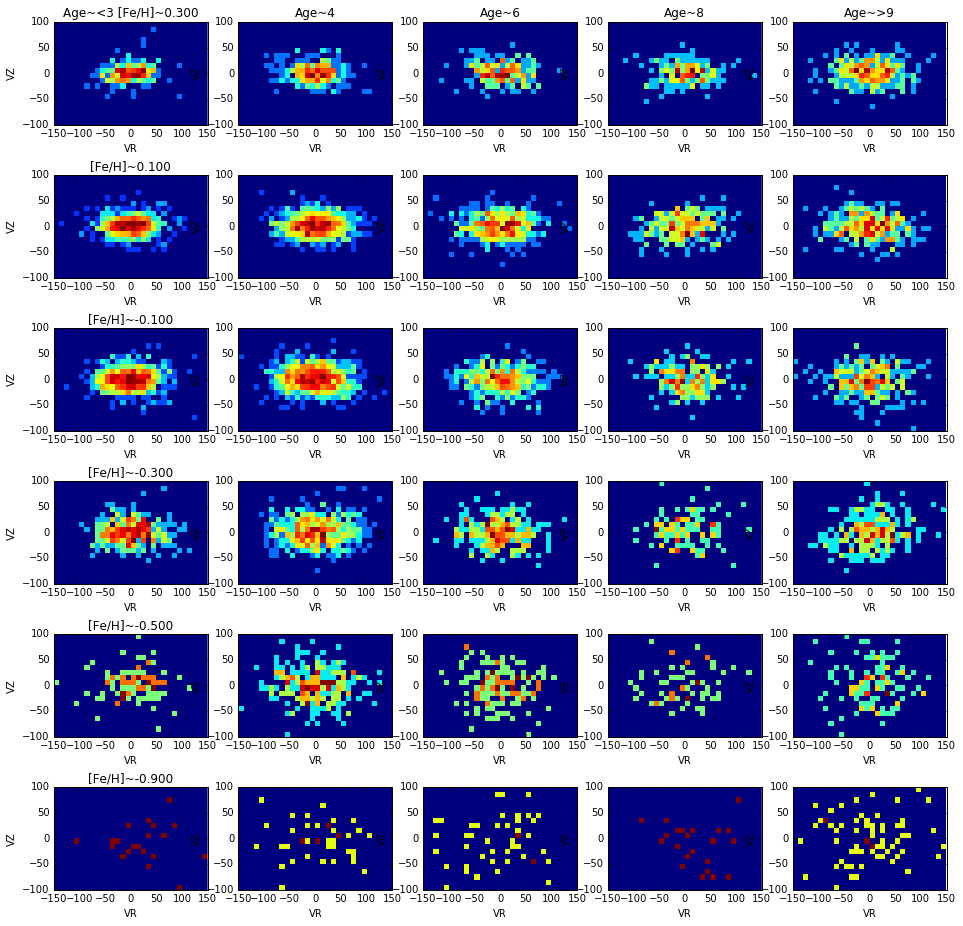

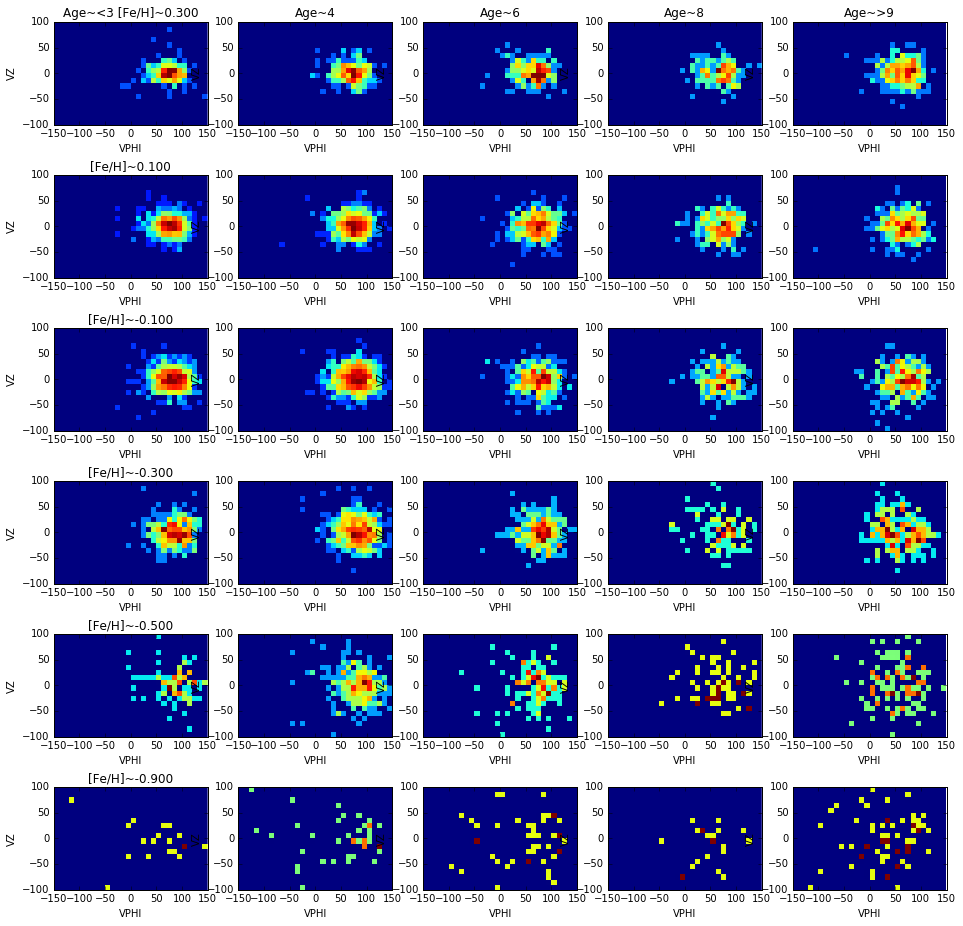

In [336]:
ind0 = ind_SGB
teffgrid = np.array([3800,5000,5500,6000,6500,7000,7500,8500])
teffcenter = (teffgrid[0:len(teffgrid)-1]+teffgrid[1:len(teffgrid)])/2.0
Age = ['<3','4','6','8','>9']
MKgrid = np.array([-10,1.07,1.6,1.85,2.0,2.5])
MKcenter = (MKgrid[0:len(MKgrid)-1]+MKgrid[1:len(MKgrid)])/2.0
fehgrid = np.array([-1.2,-0.6,-0.4,-0.2,-0.0,0.2,0.4])
fehcenter = (fehgrid[0:len(fehgrid)-1]+fehgrid[1:len(fehgrid)])/2.0
#MKmesh = np.zeros([len(teffcenter),len(fehcenter)])
VRgrid = np.linspace(-150,150,31)
VPhigrid = np.linspace(0,300,31)
VZgrid = np.linspace(-150,150,31)
fig = plt.figure(figsize=[16,16])
for i in xrange(len(MKcenter)):
    for j in xrange(len(fehcenter)):
        ind = ind0 * (tgas.MK_tgas>=MKgrid[i]) * (tgas.MK_tgas<=MKgrid[i+1]) *\
            (tgas.feh>=fehgrid[j]) * (tgas.feh<=fehgrid[j+1])
        #if np.sum(ind)>2:
        #    MKmesh[i,j]=np.median(tgas.MK_tgas[ind])
        #print (i)+(6-j)*5+1
        ax = fig.add_subplot(len(fehcenter),len(MKcenter),(i)+(len(fehcenter)-1-j)*len(MKcenter)+1)
        mp,xgrid,ygrid = np.histogram2d(VR[ind], VPHI[ind],bins=[VRgrid,VPhigrid])
        ax.imshow(np.log(1.0+mp.T),interpolation='none',extent=[-150,150,300,0])
        #ax.contourf(np.log(1.+mp.T),20,interpolation='none',extent=[-150,150,0,300])
        ax.set_xlim([-150,150])
        ax.set_ylim([100,300])
        if j==(len(fehcenter)-1) and i!=0:
            plt.title('Age~%(b)s' % {'b':Age[i]})
        if i==0 and j!=(len(fehcenter)-1):
            plt.title('[Fe/H]~%(c).3f' % {'c':fehcenter[j]})
        if i==0 and j==(len(fehcenter)-1):
            plt.title('Age~%(b)s [Fe/H]~%(c).3f' % {'b':Age[i],'c':fehcenter[j]})
        plt.xlabel('VR')
        plt.ylabel('VPhi')
fig.show()
fig.savefig('VRVPhi_AgeFeH.png')
################
fig = plt.figure(figsize=[16,16])
for i in xrange(len(MKcenter)):
    for j in xrange(len(fehcenter)):
        ind = ind0 * (tgas.MK_tgas>=MKgrid[i]) * (tgas.MK_tgas<=MKgrid[i+1]) *\
            (tgas.feh>=fehgrid[j]) * (tgas.feh<=fehgrid[j+1])
        #if np.sum(ind)>2:
        #    MKmesh[i,j]=np.median(tgas.MK_tgas[ind])
        #print (i)+(6-j)*5+1
        ax = fig.add_subplot(len(fehcenter),len(MKcenter),(i)+(len(fehcenter)-1-j)*len(MKcenter)+1)
        mp,xgrid,ygrid = np.histogram2d(VR[ind], VZ[ind],bins=[VRgrid,VZgrid])
        ax.imshow(np.log(1.0+mp.T),interpolation='none',extent=[-150,150,-150,150])
        #ax.contourf(np.log(1.+mp.T),20,interpolation='none',extent=[-150,150,0,300])
        ax.set_xlim([-150,150])
        ax.set_ylim([-100,100])
        if j==(len(fehcenter)-1) and i!=0:
            plt.title('Age~%(b)s' % {'b':Age[i]})
        if i==0 and j!=(len(fehcenter)-1):
            plt.title('[Fe/H]~%(c).3f' % {'c':fehcenter[j]})
        if i==0 and j==(len(fehcenter)-1):
            plt.title('Age~%(b)s [Fe/H]~%(c).3f' % {'b':Age[i],'c':fehcenter[j]})
        plt.xlabel('VR')
        plt.ylabel('VZ')
fig.show()
fig.savefig('VRVZ_AgeFeH.png')

################
fig = plt.figure(figsize=[16,16])
for i in xrange(len(MKcenter)):
    for j in xrange(len(fehcenter)):
        ind = ind0 * (tgas.MK_tgas>=MKgrid[i]) * (tgas.MK_tgas<=MKgrid[i+1]) *\
            (tgas.feh>=fehgrid[j]) * (tgas.feh<=fehgrid[j+1])
        #if np.sum(ind)>2:
        #    MKmesh[i,j]=np.median(tgas.MK_tgas[ind])
        #print (i)+(6-j)*5+1
        ax = fig.add_subplot(len(fehcenter),len(MKcenter),(i)+(len(fehcenter)-1-j)*len(MKcenter)+1)
        mp,xgrid,ygrid = np.histogram2d(VPHI[ind], VZ[ind],bins=[VPhigrid,VZgrid])
        ax.imshow(np.log(1.0+mp.T),interpolation='none',extent=[-150,150,-150,150])
        #ax.contourf(np.log(1.+mp.T),20,interpolation='none',extent=[-150,150,0,300])
        ax.set_xlim([-150,150])
        ax.set_ylim([-100,100])
        if j==(len(fehcenter)-1) and i!=0:
            plt.title('Age~%(b)s' % {'b':Age[i]})
        if i==0 and j!=(len(fehcenter)-1):
            plt.title('[Fe/H]~%(c).3f' % {'c':fehcenter[j]})
        if i==0 and j==(len(fehcenter)-1):
            plt.title('Age~%(b)s [Fe/H]~%(c).3f' % {'b':Age[i],'c':fehcenter[j]})
        plt.xlabel('VPHI')
        plt.ylabel('VZ')
fig.show()
fig.savefig('VPHIVZ_AgeFeH.png')

###
#fig = plt.figure(figsize=[6,6])
#ax = fig.add_subplot(111)
#im = ax.imshow(MKmesh.T,extent=[teffcenter[0],teffcenter[-1],fehcenter[-1],fehcenter[0]],interpolation='none',aspect='auto')
#plt.colorbar(im)
#fig.show()

/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:51: RuntimeWarning: invalid value encountered in less
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:76: RuntimeWarning: invalid value encountered in greater_equal
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:76: RuntimeWarning: invalid value encountered in less_equal
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:114: RuntimeWarning: invalid value encountered in divide
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:116: RuntimeWarning: invalid value encountered in divide
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:118: RuntimeWarning: invalid value encountered in divide
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:122: RuntimeWarning: invalid value encountered in divide
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:132

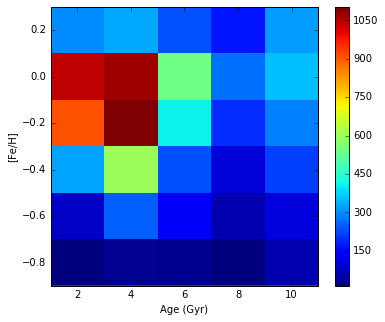

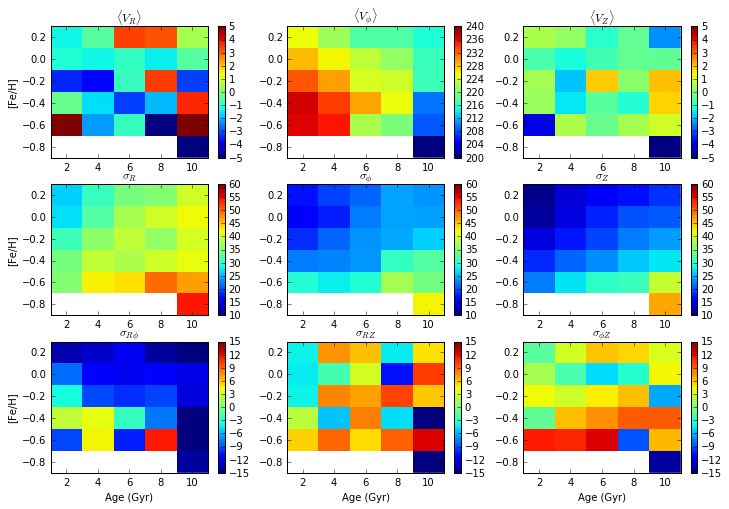

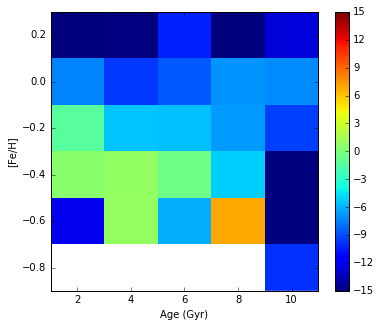

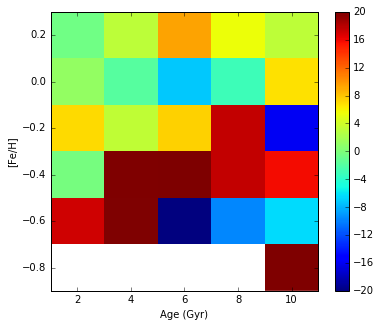

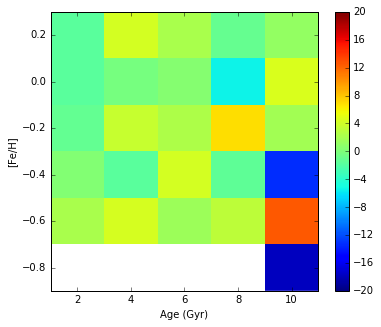

In [337]:
#calculate velocity ellipsoid
def bootstrap(func, x, N, alpha=0.15):
    '''
    Run a boots
    
    Parameters:
    func: function using x as arguement
    x: data
    N: number of repeat
    alpha: percentile
    '''
    nx = len(x)
    xb = np.random.choice(x, (nx,N), replace=True)
    #print np.shape(xb)
    yb = func(xb,axis=0)
    lower = np.percentile(yb, alpha*100)
    upper = np.percentile(yb, (1.-alpha)*100)
    return lower, upper

def bootstrap2(func, x,y, N, alpha=0.15):
    '''
    Run a boots
    
    Parameters:
    func: function using x as arguement
    x: data
    N: number of repeat
    alpha: percentile
    '''
    nx = len(x)
    xb = np.random.choice(x, (nx,N), replace=True)
    yb = np.random.choice(y, (nx,N), replace=True)
    #print (xb)
    #print yb
    zb = np.zeros([N,1])
    for i in xrange(N):
        zb [i] = func(xb[:,i],yb[:,i])
    #print zb
    lower = np.percentile(zb, alpha*100)
    upper = np.percentile(zb, (1.-alpha)*100)
    return lower, upper


def sigmaxy(x,y):
    return np.sum((x-np.mean(x))*(y-np.mean(y)))/len(x)


def sigmaxx(x,axis=0):
    return np.sum((x-np.mean(x))**2)/len(x)
    
ind0 = ind_SGB * (velerr[:,0]<225) * (velerr[:,3]<225) * (velerr[:,5]<225) *\
    (np.abs(VR)<300) * (np.abs(VPHI-238)<300) * (np.abs(VZ)<300)
meanVR = np.zeros([len(MKcenter),len(fehcenter)])
meanVPHI = np.zeros([len(MKcenter),len(fehcenter)])
meanVZ = np.zeros([len(MKcenter),len(fehcenter)])
sig_RR = np.zeros([len(MKcenter),len(fehcenter)])
sig_RPHI = np.zeros([len(MKcenter),len(fehcenter)])
sig_RZ = np.zeros([len(MKcenter),len(fehcenter)])
sig_PHIPHI = np.zeros([len(MKcenter),len(fehcenter)])
sig_PHIZ = np.zeros([len(MKcenter),len(fehcenter)])
sig_ZZ = np.zeros([len(MKcenter),len(fehcenter)])

meanVRerr = np.zeros([len(MKcenter),len(fehcenter)])
meanVPHIerr = np.zeros([len(MKcenter),len(fehcenter)])
meanVZerr = np.zeros([len(MKcenter),len(fehcenter)])
sig_RRerr = np.zeros([len(MKcenter),len(fehcenter)])
sig_RPHIerr = np.zeros([len(MKcenter),len(fehcenter)])
sig_RZerr = np.zeros([len(MKcenter),len(fehcenter)])
sig_PHIPHIerr = np.zeros([len(MKcenter),len(fehcenter)])
sig_PHIZerr = np.zeros([len(MKcenter),len(fehcenter)])
sig_ZZerr = np.zeros([len(MKcenter),len(fehcenter)])

Nmap = np.zeros([len(MKcenter),len(fehcenter)])
mask_map = np.zeros([len(MKcenter),len(fehcenter)])
for i in xrange(len(MKcenter)):
    for j in xrange(len(fehcenter)):
        ind = ind0 * (tgas.MK_tgas>=MKgrid[i]) * (tgas.MK_tgas<=MKgrid[i+1]) *\
            (tgas.feh>=fehgrid[j]) * (tgas.feh<=fehgrid[j+1])
        Nmap[i,j] = np.sum(ind)
        #print np.sum(ind)
        if np.sum(ind)>50:
            mask_map[i,j] = 1
            meanVR[i,j] = np.mean(VR[ind])
            meanVPHI[i,j] = np.mean(VPHI[ind])
            meanVZ[i,j] = np.mean(VZ[ind])
            sig_RR[i,j] = np.sum((VR[ind]-meanVR[i,j])**2)/np.sum(ind)-np.mean(velerr[ind,0])
            sig_RPHI[i,j] = np.sum((VR[ind]-meanVR[i,j])*(VPHI[ind]-meanVPHI[i,j]))/np.sum(ind)-np.mean(velerr[ind,1])
            sig_RZ[i,j] = np.sum((VR[ind]-meanVR[i,j])*(VZ[ind]-meanVZ[i,j]))/np.sum(ind)-np.mean(velerr[ind,2])
            sig_PHIPHI[i,j] = np.sum((VPHI[ind]-meanVPHI[i,j])**2)/np.sum(ind)-\
                np.mean(velerr[ind,3])
            sig_PHIZ[i,j] = np.sum((VPHI[ind]-meanVPHI[i,j])*(VZ[ind]-meanVZ[i,j]))/np.sum(ind)-np.mean(velerr[ind,4])
            sig_ZZ[i,j] = np.sum((VZ[ind]-meanVZ[i,j])**2)/np.sum(ind)-np.mean(velerr[ind,5])
            ###############
            ci = bootstrap(np.mean, VR[ind], 100, alpha=0.15)
            meanVRerr[i,j] = (ci[1]-ci[0])/2.0
            ci = bootstrap(np.mean, VPHI[ind], 100, alpha=0.15)
            meanVPHIerr[i,j] = (ci[1]-ci[0])/2.0
            ci = bootstrap(np.mean, VZ[ind], 100, alpha=0.15)
            meanVZerr[i,j] = (ci[1]-ci[0])/2.0
            ci = bootstrap(np.var,VR[ind],100,alpha=0.15)
            sig_RRerr[i,j] = (ci[1]-ci[0])/2.0
            ci = bootstrap(np.var,VPHI[ind],100,alpha=0.15)
            sig_PHIPHIerr[i,j] = (ci[1]-ci[0])/2.0
            ci = bootstrap(np.var,VZ[ind],100,alpha=0.15)
            sig_ZZerr[i,j] = (ci[1]-ci[0])/2.0
            ci = bootstrap2(sigmaxy,VR[ind],VPHI[ind],100,alpha=0.15)
            sig_RPHIerr[i,j] = (ci[1]-ci[0])/2.0
            ci = bootstrap2(sigmaxy,VR[ind],VZ[ind],100,alpha=0.15)
            sig_RZerr[i,j] = (ci[1]-ci[0])/2.0
            ci = bootstrap2(sigmaxy,VPHI[ind],VZ[ind],100,alpha=0.15)
            sig_PHIZerr[i,j] = (ci[1]-ci[0])/2.0
        else:
            mask_map[i,j]=np.NAN    

#lv = 0.5*np.arctan(2*sig_RPHI/(sig_RR-sig_PHIPHI))*180.0/np.pi
vv=sig_RR-sig_PHIPHI
u = 2*sig_RPHI/(vv)
lv = 0.5*np.arctan(u)*180.0/np.pi
lverr = np.sqrt((0.5/(1+u**2))**2*(4*sig_RPHIerr/vv**2+4*sig_RPHI**2/vv**4*sig_RRerr+\
                                   4*sig_RPHI**2/vv**4*sig_PHIPHIerr))
vv=sig_PHIPHI-sig_ZZ
u = 2*sig_PHIZ/(vv)
Alpha_PHIZ = 0.5*np.arctan(u)*180.0/np.pi

vv=sig_RR-sig_ZZ
u = 2*sig_RZ/(vv)
Alpha_RZ = 0.5*np.arctan(u)*180.0/np.pi

sig_RR = np.sqrt(sig_RR)
sig_RPHI = np.sign(sig_RPHI)*np.sqrt(np.abs(sig_RPHI))
sig_RZ = np.sign(sig_RZ)*np.sqrt(np.abs(sig_RZ))
sig_PHIPHI = np.sqrt(sig_PHIPHI)
sig_PHIZ = np.sign(sig_PHIZ)*np.sqrt(np.abs(sig_PHIZ))
sig_ZZ = np.sqrt(sig_ZZ)

sRRerr=np.sqrt(sig_RRerr/(4*np.abs(sig_RR)))
sRPHIerr=np.sqrt(sig_RPHIerr/(4*np.abs(sig_RPHI)))
sRZerr=np.sqrt(sig_RZerr/(4*np.abs(sig_RZ)))
sPHIPHIerr=np.sqrt(sig_PHIPHIerr/(4*np.abs(sig_PHIPHI)))
sPHIZerr=np.sqrt(sig_PHIZerr/(4*np.abs(sig_PHIZ)))
sZZerr=np.sqrt(sig_ZZerr/(4*np.abs(sig_ZZ)))


tlabs = [r'$\langle V_R\rangle$',r'$\langle V_\phi\rangle$',r'$\langle V_Z\rangle$',\
         r'$\sigma_R$',r'$\sigma_\phi$',r'$\sigma_Z$',\
         r'$\sigma_{R\phi}$',r'$\sigma_{RZ}$',r'$\sigma_{\phi Z}$']
sig = [meanVR,meanVPHI,meanVZ,sig_RR,sig_PHIPHI,sig_ZZ,sig_RPHI,sig_RZ,sig_PHIZ]

fig = plt.figure(figsize=[6,5])
ax = fig.add_subplot(111)
im = ax.imshow(Nmap.T,extent=[0,10,fehcenter[-1],fehcenter[0]],aspect='auto',interpolation='none')
plt.colorbar(im)
ax.set_ylim([fehcenter[0],fehcenter[-1]])
ax.set_xlim([0,10])
plt.xticks([1,3,5,7,9],('2','4','6','8','10'))
plt.xlabel('Age (Gyr)')
plt.ylabel('[Fe/H]')

fig.show()
fig.savefig('Nstars_AM.png')

#############
vm=[[-5,5],[200,240],[-5,5],[10,60],[10,60],[10,60],[-15,15],[-15,15],[-15,15]]
fig = plt.figure(figsize=[12,8])
for i in xrange(9):
    ax = fig.add_subplot(3,3,i+1)
    im = ax.imshow(sig[i].T*mask_map.T,vmin=vm[i][0],vmax=vm[i][1],\
                   extent=[0,10,fehcenter[-1],fehcenter[0]],aspect='auto',interpolation='none')
    plt.colorbar(im)
    plt.title(tlabs[i])
    ax.set_xlim([0,10])
    ax.set_ylim([fehcenter[0],fehcenter[-1]])
    plt.xticks([1,3,5,7,9],('2','4','6','8','10'))
    ax.set_ylim([fehcenter[0],fehcenter[-1]])
    if i>=6:
        plt.xlabel('Age (Gyr)')
    if i==0 or i==3 or i==6:
        plt.ylabel('[Fe/H]')
fig.show()
fig.savefig('velellip_AM.png')
##########
fig = plt.figure(figsize=[6,5])
ax = fig.add_subplot(111)
im = ax.imshow(lv.T*mask_map.T,vmin=-15,vmax=15,\
               extent=[0,10,fehcenter[-1],fehcenter[0]],aspect='auto',interpolation='none')
plt.colorbar(im)
ax.set_ylim([fehcenter[0],fehcenter[-1]])
ax.set_xlim([0,10])
plt.xticks([1,3,5,7,9],('2','4','6','8','10'))
plt.xlabel('Age (Gyr)')
plt.ylabel('[Fe/H]')

fig.show()
fig.savefig('vertex_deviation_AM.png')
##########
fig = plt.figure(figsize=[6,5])
ax = fig.add_subplot(111)
im = ax.imshow(Alpha_PHIZ.T*mask_map.T,vmin=-20,vmax=20,\
               extent=[0,10,fehcenter[-1],fehcenter[0]],aspect='auto',interpolation='none')
plt.colorbar(im)
ax.set_ylim([fehcenter[0],fehcenter[-1]])
ax.set_xlim([0,10])
plt.xticks([1,3,5,7,9],('2','4','6','8','10'))
plt.xlabel('Age (Gyr)')
plt.ylabel('[Fe/H]')

fig.show()
fig.savefig('Alpha_PHIZ_AM.png')
##########
fig = plt.figure(figsize=[6,5])
ax = fig.add_subplot(111)
im = ax.imshow(Alpha_RZ.T*mask_map.T,vmin=-20,vmax=20,\
               extent=[0,10,fehcenter[-1],fehcenter[0]],aspect='auto',interpolation='none')
plt.colorbar(im)
ax.set_ylim([fehcenter[0],fehcenter[-1]])
ax.set_xlim([0,10])
plt.xticks([1,3,5,7,9],('2','4','6','8','10'))
plt.xlabel('Age (Gyr)')
plt.ylabel('[Fe/H]')

fig.show()
fig.savefig('Alpha_RZ_AM.png')

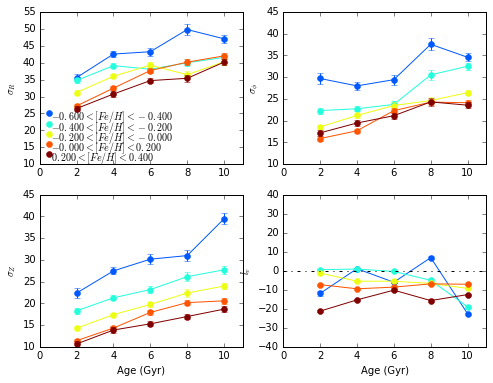

In [338]:
#only look at sigma
def colorPattern(n,type='jet'):
    '''
    Set different color map pattern
    
    Parameters: type='jet','gray','invgray'
    '''
    x=np.linspace(0,63,n)
    c=np.ndarray([len(x),3])
    if type=='jet':
        c[(x<=23),0] = 0.
        c[(x<=7)+(x>56),1] = 0.
        c[(x>39),2] = 0.
        
        c[(x>23) * (x<=39),0] = (x[(x>23) * (x<=39)]-23.)/(39.-23.)
        c[(x>7)*(x<=23),1] = (x[(x>7) * (x<=23)]-7.)/(23.-7.)
        c[(x<=7.),2] = (x[(x<=7.)]+7.)/(7.+7.)
        
        c[(x>39) * (x<=56),0] = 1.
        c[(x>23) * (x<=39),1] = 1.
        c[(x>7) * (x<=23),2] = 1.
        
        c[(x>56),0] = (70.-x[(x>56)])/(70.-56.)
        c[(x>39)*(x<=56),1] = (56.-x[(x>39) * (x<=56)])/(56.-39.)
        c[(x>23)*(x<=39),2] = (39.-x[(x>23) * (x<=39)])/(39.-23.)                
        
    else:
        if type=='gray':
            c[:,0] = x/63.
            c[:,1] = x/63.
            c[:,2] = x/63.
        else:#invgray
            c[:,0] = 1-x/63.
            c[:,1] = 1-x/63.
            c[:,2] = 1-x/63.
    return c
    
cols=colorPattern(6)
agecenter=[2,4,6,8,10]
fig = plt.figure(figsize=[8,6])
ax = fig.add_subplot(221)
for i in xrange(len(fehcenter)):
    if i>0:
        ax.errorbar(agecenter,sig_RR[:,i],yerr=sRRerr[:,i],fmt='-o',color=cols[i,:],markeredgecolor=cols[i,:])
        ax.plot(0.5,28-i*3,'o',color=cols[i,:],markeredgecolor=cols[i,:])
        ax.text(0.6,26-i*3,r'$%(a).3f<[Fe/H]<%(b).3f$' % {'a':fehgrid[i],'b':fehgrid[i+1]})
ax.set_xlim([0,11])
ax.set_ylim([10,55])
plt.ylabel(r'$\sigma_R$')
#################
ax = fig.add_subplot(222)
for i in xrange(len(fehcenter)):
    if i>0:
        ax.errorbar(agecenter,sig_PHIPHI[:,i],yerr=sPHIPHIerr[:,i],\
                    fmt='-o',color=cols[i,:],markeredgecolor=cols[i,:])
ax.set_xlim([0,11])
ax.set_ylim([10,45])
plt.ylabel(r'$\sigma_\phi$')
##################
ax = fig.add_subplot(223)
for i in xrange(len(fehcenter)):
    if i>0:
        ax.errorbar(agecenter,sig_ZZ[:,i],yerr=sZZerr[:,i],fmt='-o',color=cols[i,:],markeredgecolor=cols[i,:])
ax.set_xlim([0,11])
ax.set_ylim([10,45])
plt.xlabel('Age (Gyr)')
plt.ylabel(r'$\sigma_Z$')
##################
ax = fig.add_subplot(224)
for i in xrange(len(fehcenter)):
    if i>0:
        ax.errorbar(agecenter,lv[:,i],yerr=lverr[:,i]*180.0/np.pi,fmt='-o',color=cols[i,:],markeredgecolor=cols[i,:])
ax.plot([0,12],[0,0],'k-.')
ax.set_xlim([0,11])
ax.set_ylim([-40,40])
plt.xlabel('Age (Gyr)')
plt.ylabel(r'$l_v$')

fig.show()
fig.savefig('vdip_age.png')




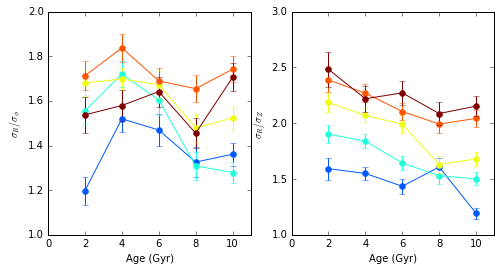

In [339]:
fig = plt.figure(figsize=[8,4])
ax = fig.add_subplot(121)
for i in xrange(len(fehcenter)):
    if i>0:
        ax.errorbar(agecenter,sig_RR[:,i]/sig_PHIPHI[:,i],\
                    yerr=np.sqrt(sRRerr[:,i]**2/sig_PHIPHI[:,i]**2+\
                    sPHIPHIerr[:,i]**2*sig_RR[:,i]**2/sig_PHIPHI[:,i]**4),\
                    fmt='-o',color=cols[i,:],markeredgecolor=cols[i,:])
        #ax.plot(0.5,28-i*3,'o',color=cols[i,:],markeredgecolor=cols[i,:])
        #ax.text(0.6,26-i*3,r'$%(a).3f<[Fe/H]<%(b).3f$' % {'a':fehgrid[i],'b':fehgrid[i+1]})
ax.set_xlim([0,11])
ax.set_ylim([1,2])
plt.ylabel(r'$\sigma_R/\sigma_\phi$')
plt.xlabel('Age (Gyr)')
#################
ax = fig.add_subplot(122)
for i in xrange(len(fehcenter)):
    if i>0:
        ax.errorbar(agecenter,sig_RR[:,i]/sig_ZZ[:,i],\
                    yerr=np.sqrt(sRRerr[:,i]**2/sig_ZZ[:,i]**2+\
                    sZZerr[:,i]**2*sig_RR[:,i]**2/sig_ZZ[:,i]**4),\
                    fmt='-o',color=cols[i,:],markeredgecolor=cols[i,:])
        #ax.plot(0.5,28-i*3,'o',color=cols[i,:],markeredgecolor=cols[i,:])
        #ax.text(0.6,26-i*3,r'$%(a).3f<[Fe/H]<%(b).3f$' % {'a':fehgrid[i],'b':fehgrid[i+1]})
ax.set_xlim([0,11])
ax.set_ylim([1,3])
plt.ylabel(r'$\sigma_R/\sigma_Z$')
plt.xlabel('Age (Gyr)')
fig.show()

fig.savefig('sigmaratio_age.png')

In [341]:
lverr*180.0/np.pi

array([[        nan,  1.4284559 ,  0.58042095,  0.36789449,  0.44016102,
         0.57927394],
       [        nan,  0.46807187,  0.35892973,  0.30908469,  0.31613865,
         0.51893702],
       [        nan,  0.56890913,  0.53134411,  0.39269826,  0.35415657,
         0.52811088],
       [        nan,  0.86245003,  1.02935752,  0.60178611,  0.39832449,
         0.62230547],
       [ 0.80996564,  0.45122698,  0.60524121,  0.49346152,  0.34203453,
         0.36138972]])

In [ ]:
print lverr